### Download Data

The data is taken from http://archive.ics.uci.edu/ml/machine-learning-databases/00240/, but you can have it in the form of the UCI-HAR-Dataset.zip.

Extract it to the folder of your notebook with the solution (or suitably adjust the paths to training and test data specified below (TRAIN, TEST).  

Spcifically, the split into training and testing data is already done. The dataset contains 7352 training and 2947 test samples.  

Each sample consists of nine timeseries of float values, each of length 128.

The nine timeseries are collected by an accelerometer and a gyroscope that contain information about the motion and the orientation, respectively.

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

torch.manual_seed(42)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Torch version: {torch.__version__}, Device: {device.type}')

Torch version: 2.6.0, Device: mps


### Load Data

In [3]:
# Useful Constants
TRAIN = "../../data/UCI_HAR_Dataset/train/"
TEST = "../../data/UCI_HAR_Dataset/test/"

# x-values, 'signals'
# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]
X_train_signals_paths = [TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES]
X_test_signals_paths =  [TEST  + "Inertial Signals/" + signal + "test.txt"  for signal in INPUT_SIGNAL_TYPES]


# y-values, 'labels'
#Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]
N_CLASSES = len(LABELS)
y_train_path = TRAIN + "y_train.txt"
y_test_path  = TEST  + "y_test.txt"

In [4]:
# Load "X" (the neural network's training and testing inputs)
def load_X(X_signals_paths):
    X_signals = []
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
print(X_train.shape, X_test.shape)

(7352, 128, 9) (2947, 128, 9)


In [5]:
# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

def one_hot(y, n_classes):
    y = y.reshape(len(y))
    return np.eye(n_classes)[np.array(y, dtype=np.int32)]

def label_from_onehot(vectors):
    indices = []
    for vector in vectors:
        indices.append(np.argmax(vector))
    return np.array(indices)

Y_train = load_y(y_train_path)
Y_test = load_y(y_test_path)
print(Y_train.shape, Y_test.shape)

(7352, 1) (2947, 1)


#### Plot some samples

In [6]:
X_train_per_class = {}
for c in range(N_CLASSES):
    mask = Y_train.flatten() == c
    X_train_per_class[c] = X_train[mask]

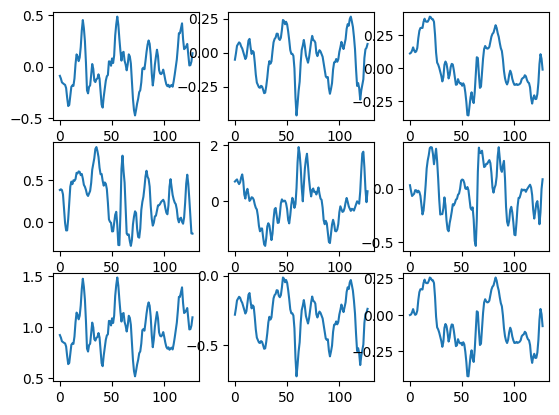

In [7]:
def plot_lines(X, nsamples):
    t = range(128)
    for i in range(9):
        plt.subplot(3,3,i+1)
        for j in range(np.minimum(X.shape[0],nsamples)):
            plt.plot(t,X[j,:,i])
    plt.show()
    
plot_lines(X_train_per_class[1], 1)

In [8]:
# Input Data
training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
means = np.mean(X_train, axis=(0,1))
stdevs = np.std(X_train, axis=(0,1))

print("X shape, Y_shape:")
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print()
print("Mean / Stdev for each feature:")
for i in range(9):
    print("%7.4f | %7.4f"%(means[i], stdevs[i]))

X shape, Y_shape:
(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)

Mean / Stdev for each feature:
-0.0006 |  0.1948
-0.0003 |  0.1224
-0.0003 |  0.1069
 0.0005 |  0.4068
-0.0008 |  0.3819
 0.0001 |  0.2557
 0.8047 |  0.4141
 0.0288 |  0.3910
 0.0865 |  0.3578


### Dataset

If suitable specify Dataset (e.g. in PyTorch).

In [9]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, normalize=True):
        # Convert to float32 tensor
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long).flatten()

        if normalize:
            # Normalize per channel (last dimension)
            mean = X.mean(dim=(0, 1), keepdim=True)
            std = X.std(dim=(0, 1), keepdim=True) + 1e-8  # avoid division by zero
            X = (X - mean) / std

        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [10]:
train_data = TimeSeriesDataset(X_train, Y_train, normalize=True)
test_data = TimeSeriesDataset(X_test, Y_test, normalize=True)

## Specify and Train Models

Try different architectures to solve the activity recognition problem.

At minimum implement
* Model with a single layer of SimpleRNN
* Model with a single layer of LSTM
* Model with several layers of LSTMs
* Model with several CNN layers
* MLP

Try with different number of units. Add regularisation if needed (e.g. when working with MLPs).

Report about your findings.

## Training Loop

In [11]:
def trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs):
    """
    Trains and evaluates the model for n_epochs.
    """
    total_batches = n_epochs * len(train_loader)
    progress = tqdm(total=total_batches, desc="Training Progress", leave=True)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    y_preds, y_trues = [], []

    for epoch in range(n_epochs):
        train_loss = 0
        train_correct = 0
        train_total = 0

        model.train()
        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(device), y_train.to(device)

            optimizer.zero_grad()
            output = model(X_train)
            loss = criterion(output, y_train)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, y_pred = torch.max(output, 1)
            train_correct += (y_pred == y_train).sum().item()
            train_total += y_train.size(0)

            progress.update(1)

        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)

        val_loss = 0
        val_correct = 0
        val_total = 0

        model.eval()
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                output = model(X_val)
                loss = criterion(output, y_val)

                val_loss += loss.item()
                _, y_pred = torch.max(output, 1)
                y_preds.append(y_pred.detach().cpu())
                y_trues.append(y_val.detach().cpu())
                val_correct += (y_pred == y_val).sum().item()
                val_total += y_val.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)

        progress.set_postfix({
            'Epoch': f'{epoch + 1}/{n_epochs}',
            'Train Loss': f'{avg_train_loss:.4f}',
            'Val Loss': f'{avg_val_loss:.4f}',
            'Train Acc': f'{train_acc:.4f}',
            'Val Acc': f'{val_acc:.4f}'
        })
    
    y_preds = torch.cat(y_preds).numpy()
    y_trues = torch.cat(y_trues).numpy()

    progress.close()
    return train_losses, val_losses, train_accs, val_accs, y_preds, y_trues

## Plot Loss Curves

In [12]:
def plot_loss_curve(n_epochs, train_losses, val_losses, train_acc, val_acc, y_preds, y_trues, title):
    
    fig, ax = plt.subplots(1, 3, figsize=(14,4), layout='tight')

    ax[0].plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
    ax[0].plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_xticks(range(1, n_epochs+1))
    ax[0].set_ylabel('Loss')
    ax[0].grid()
    ax[0].legend()

    ax[1].plot(range(1, n_epochs + 1), train_acc, label='Training Accuracy')
    ax[1].plot(range(1, n_epochs + 1), val_acc, label='Validation Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_xticks(range(1, n_epochs+1))
    ax[1].set_ylabel('Accuracy')
    ax[1].set_ylim(0,1)
    ax[1].grid()
    ax[1].legend()

    cm = confusion_matrix(y_trues, y_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax[2])
    
    fig.suptitle(title)
    plt.show()

In [13]:
results = {}

### Single Layer SimpleRNN

In [14]:
### START YOUR CODE
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers=1):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, h = self.rnn(x)
        return self.fc(h[-1])

### END YOUR CODE

In [15]:
### START YOUR CODE
n_epochs = 20
batch_sizes = [64, 128, 256]
input_dim = X_train.shape[2]
hidden_dims = [64, 128, 256]
output_dim = len(np.unique(Y_train))

for batch_size in batch_sizes:
    train_loader = DataLoader(train_data, batch_size, shuffle=False)
    val_loader = DataLoader(test_data, batch_size, shuffle=False)

    for hidden_dim in hidden_dims:
        model = RNN(input_dim, hidden_dim, output_dim).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters())

        train_losses, test_losses, train_accs, test_accs, y_preds, y_trues = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)
        results[f'RNN with batch size {batch_size} | hidden dim: {hidden_dim}'] = train_losses, test_losses, train_accs, test_accs, y_preds, y_trues

Training Progress: 100%|██████████| 580/580 [00:34<00:00, 17.03it/s, Epoch=20/20, Train Loss=1.1502, Val Loss=1.2592, Train Acc=0.5333, Val Acc=0.4907]


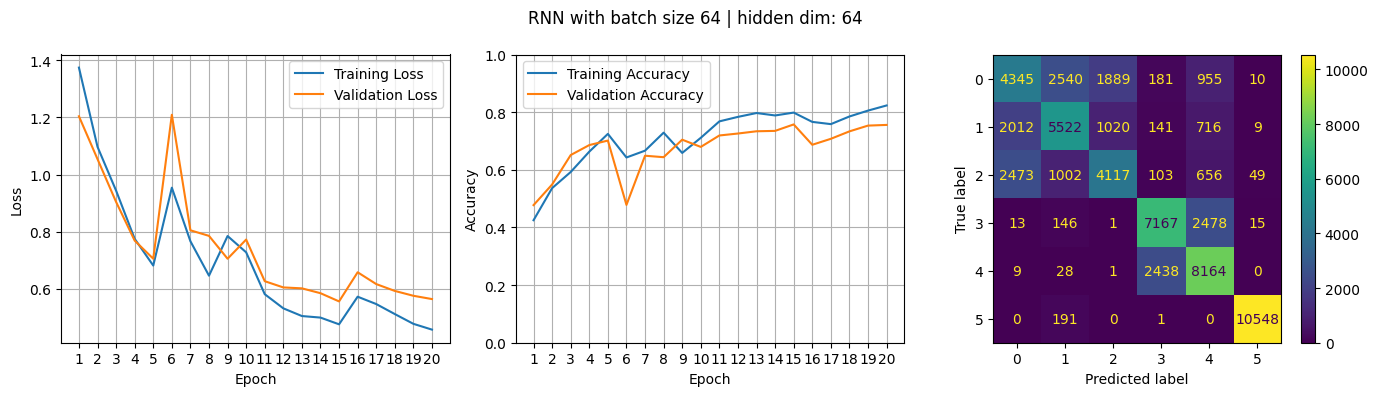

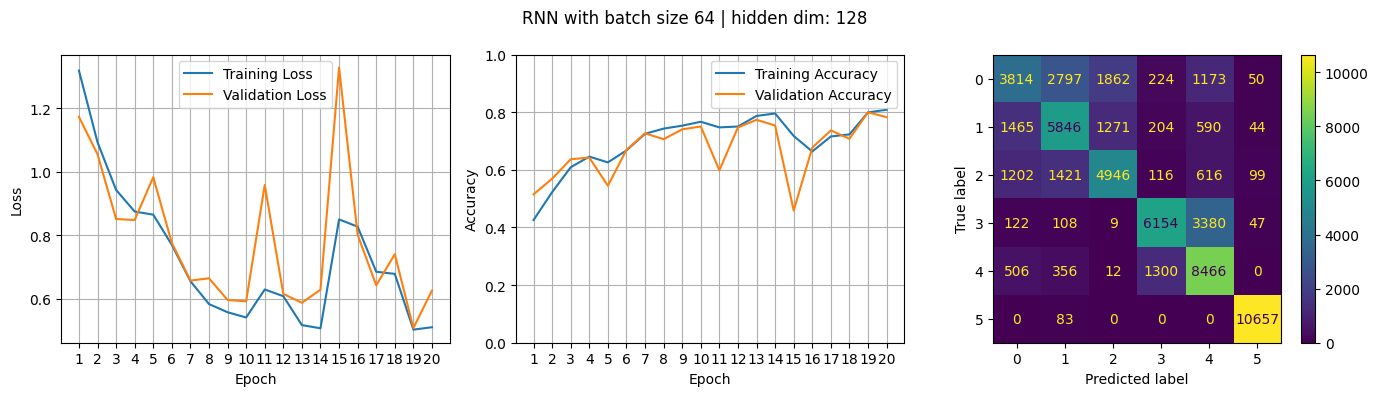

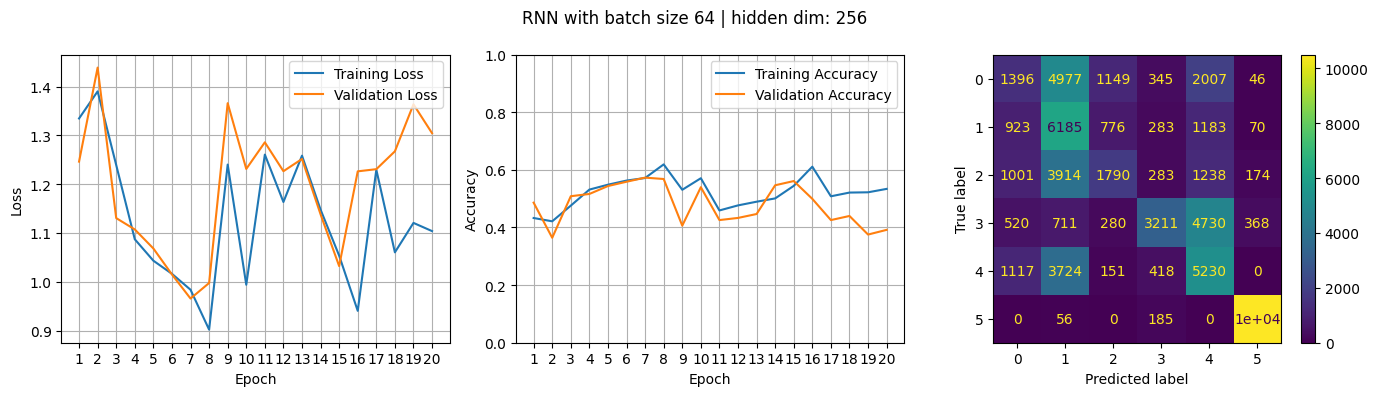

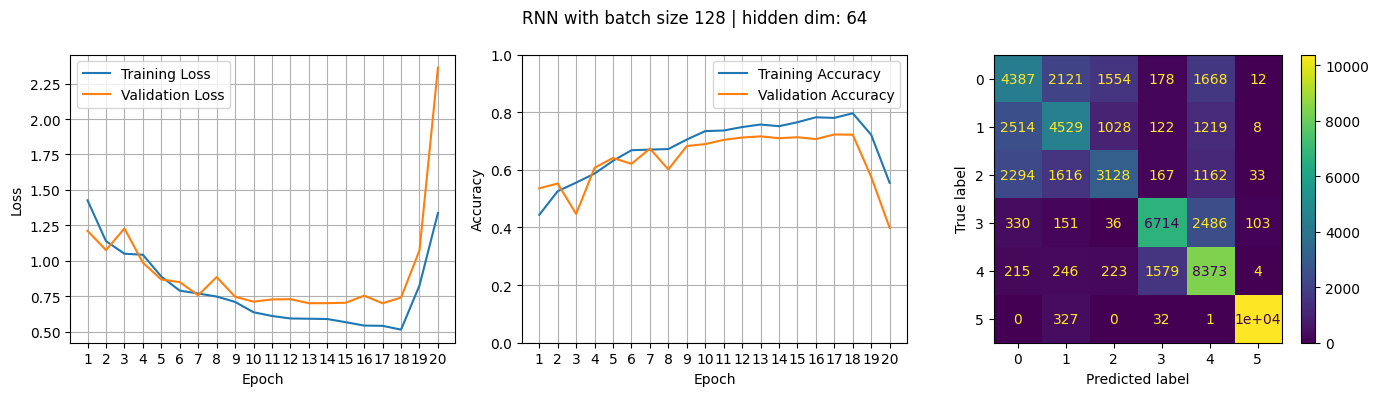

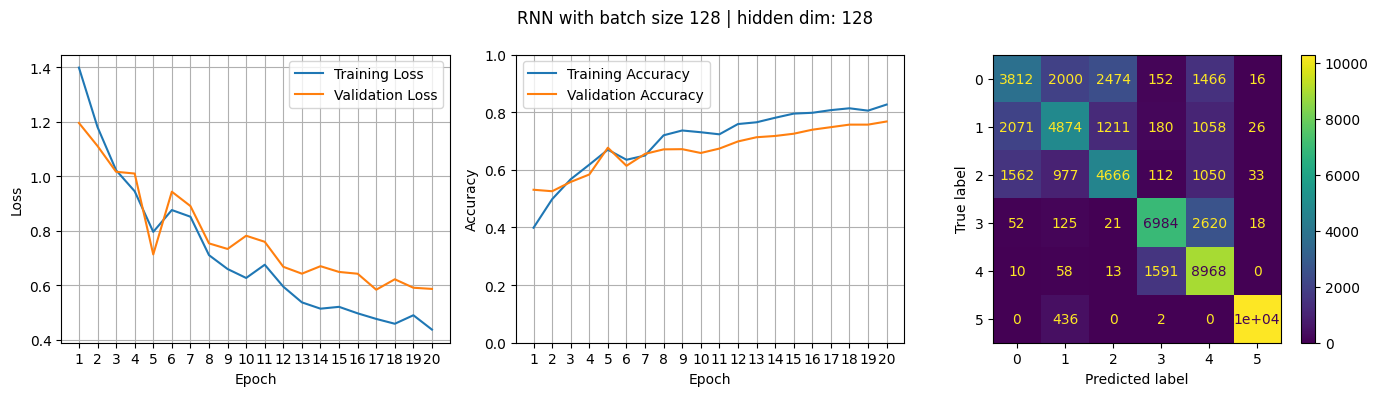

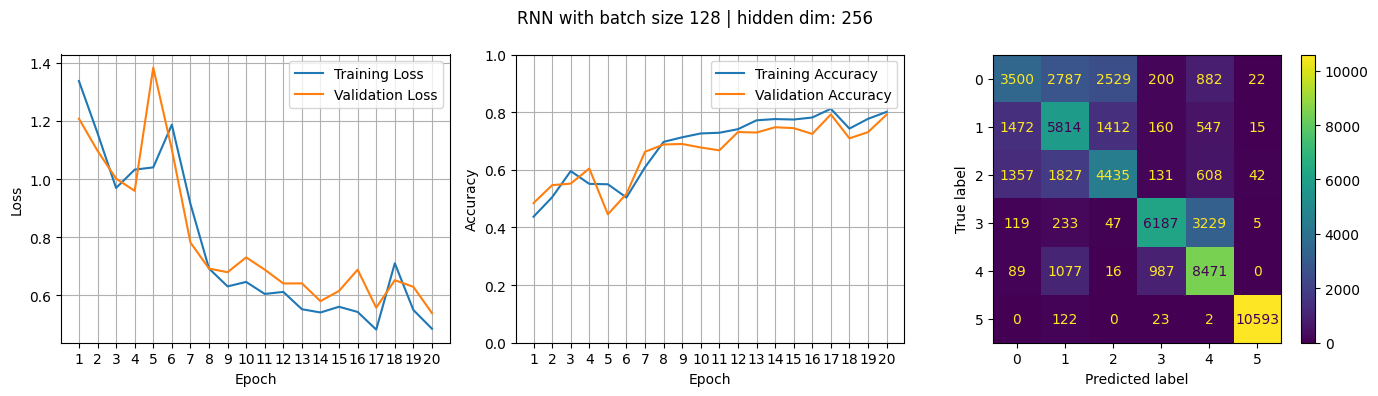

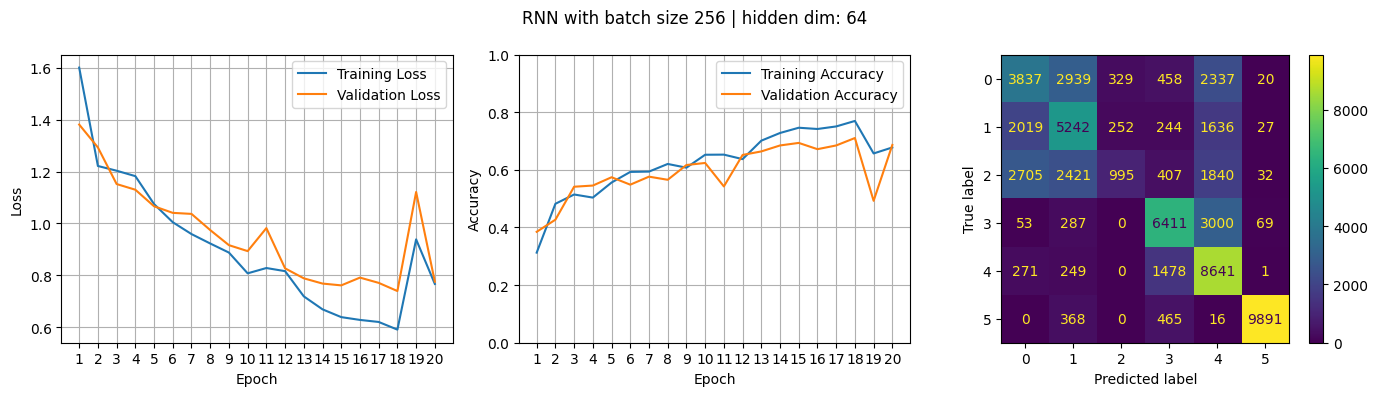

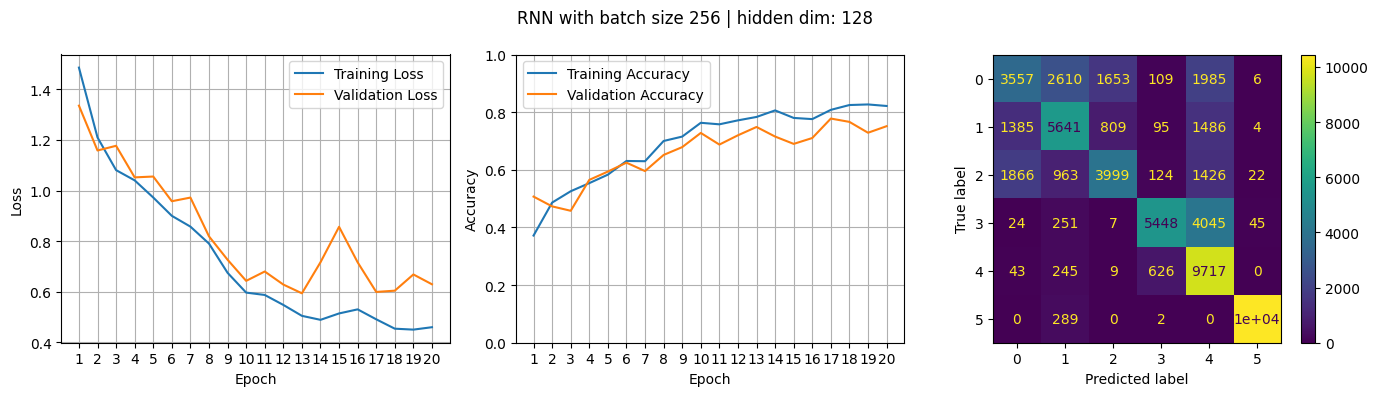

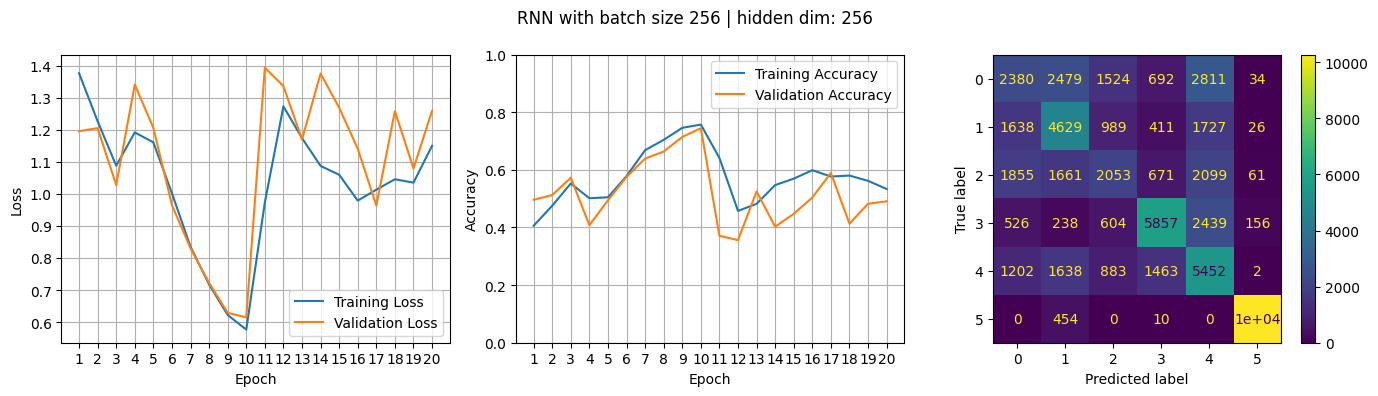

In [16]:
simple_rnn_results = {k: v for k, v in results.items() if k.startswith('RNN with batch size')}

for key, values in simple_rnn_results.items():
    plot_loss_curve(n_epochs, values[0], values[1], values[2], values[3], values[4], values[5], key)

#### Findings

...

### LSTM

In [17]:
### START YOUR CODE
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n[-1])
### END YOUR CODE

In [18]:
### START YOUR CODE
n_epochs = 20
batch_sizes = [64, 128, 256]
input_dim = X_train.shape[2]
hidden_dims = [64, 128, 256]
output_dim = len(np.unique(Y_train))

for batch_size in batch_sizes:
    train_loader = DataLoader(train_data, batch_size, shuffle=False)
    val_loader = DataLoader(test_data, batch_size, shuffle=False)

    for hidden_dim in hidden_dims:
        model = LSTM(input_dim, hidden_dim, output_dim).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters())

        train_losses, test_losses, train_accs, test_accs, y_preds, y_trues = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)
        results[f'LSTM with batch size {batch_size} | hidden dim: {hidden_dim}'] = train_losses, test_losses, train_accs, test_accs, y_preds, y_trues

Training Progress: 100%|██████████| 580/580 [00:44<00:00, 13.01it/s, Epoch=20/20, Train Loss=0.1904, Val Loss=0.2992, Train Acc=0.9276, Val Acc=0.8877]


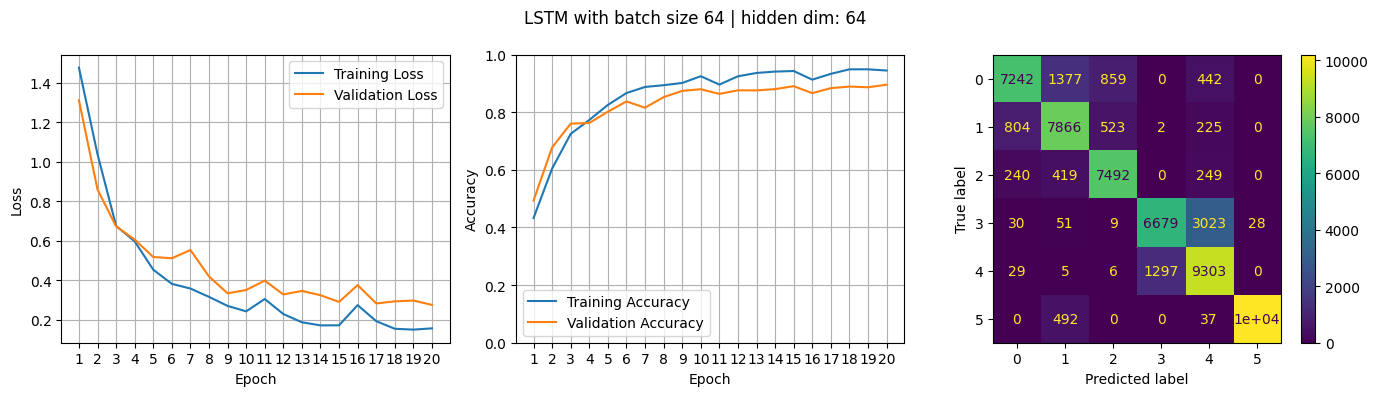

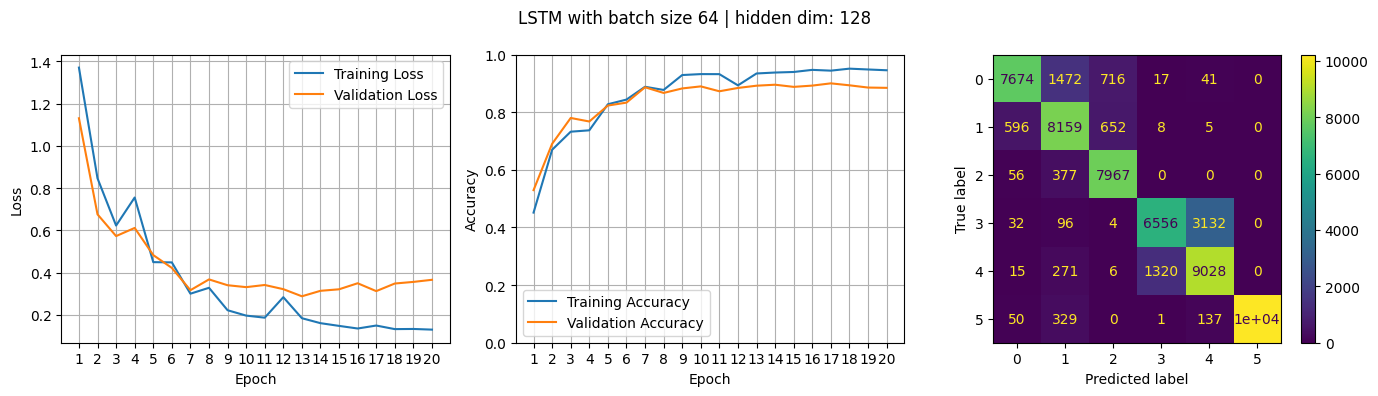

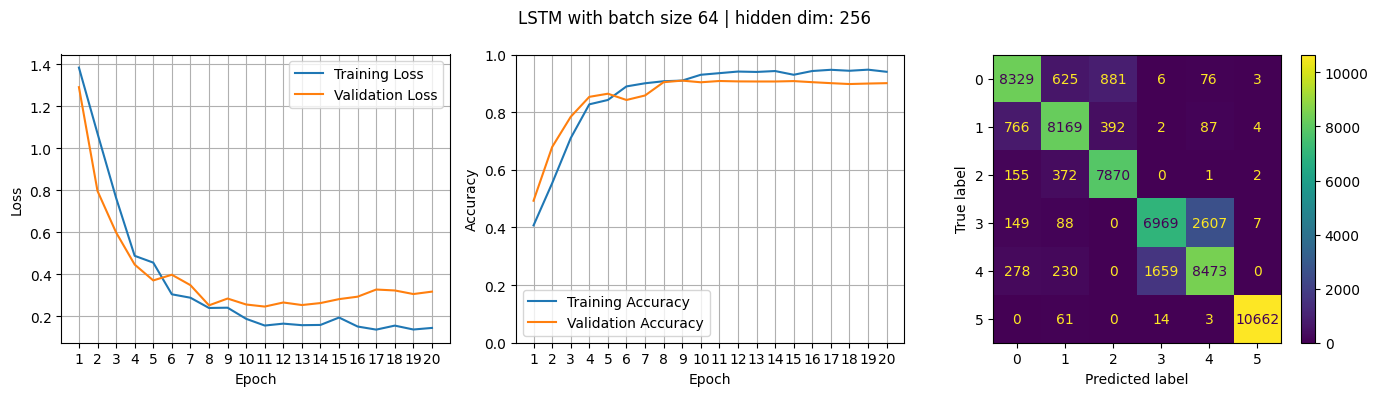

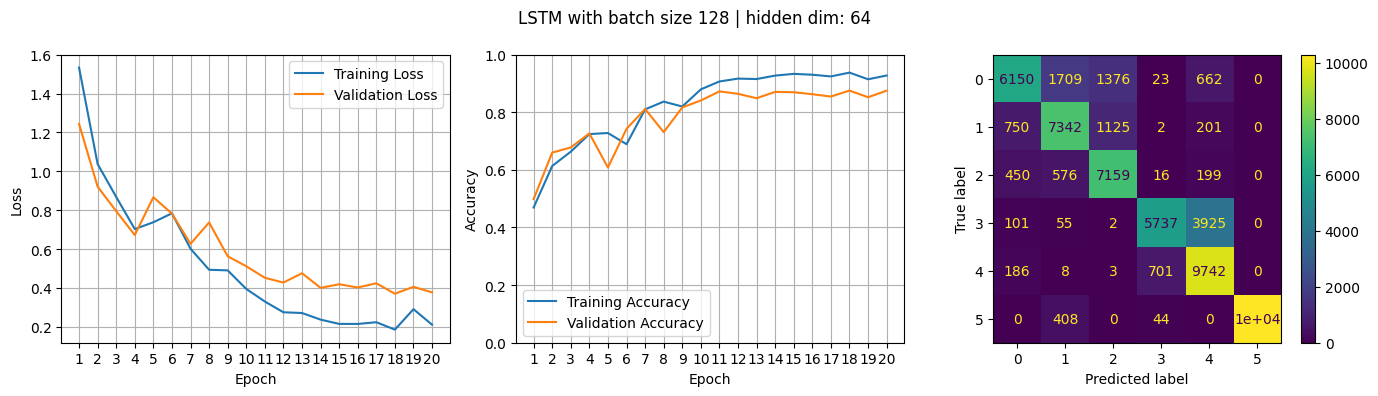

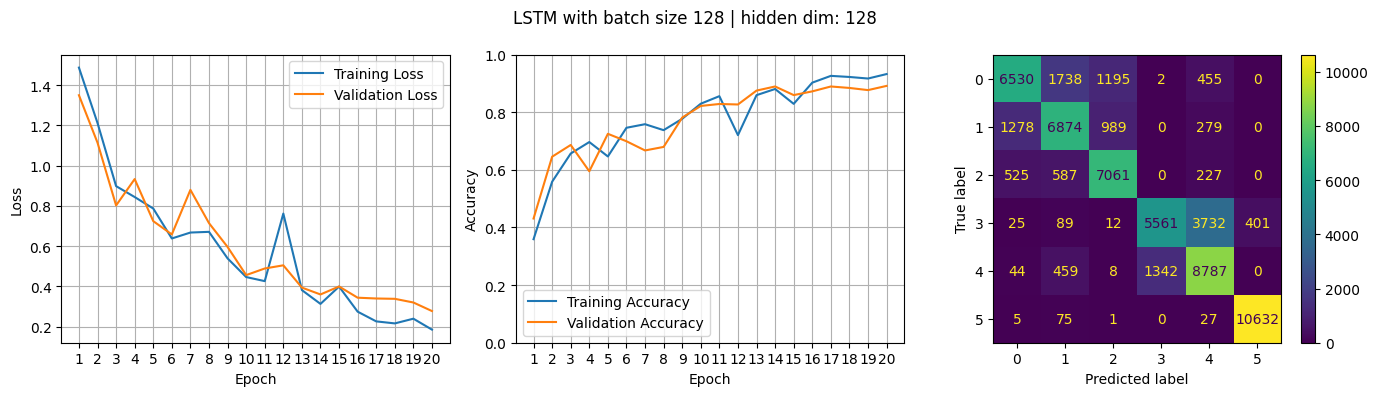

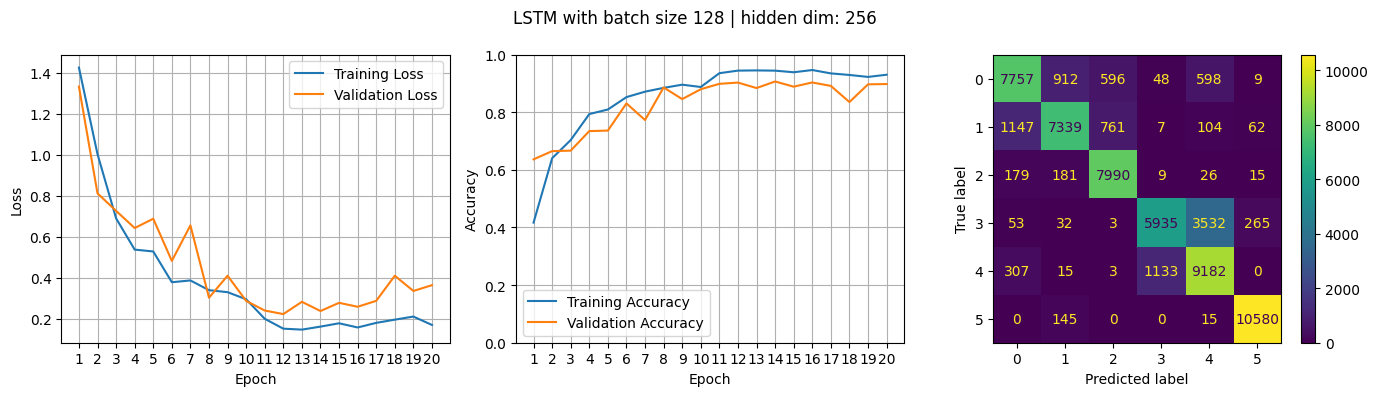

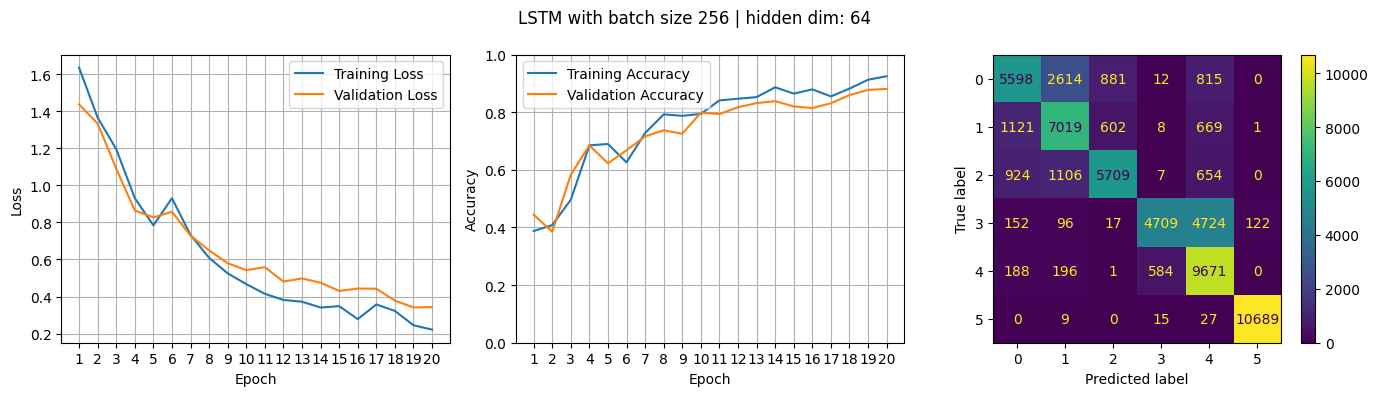

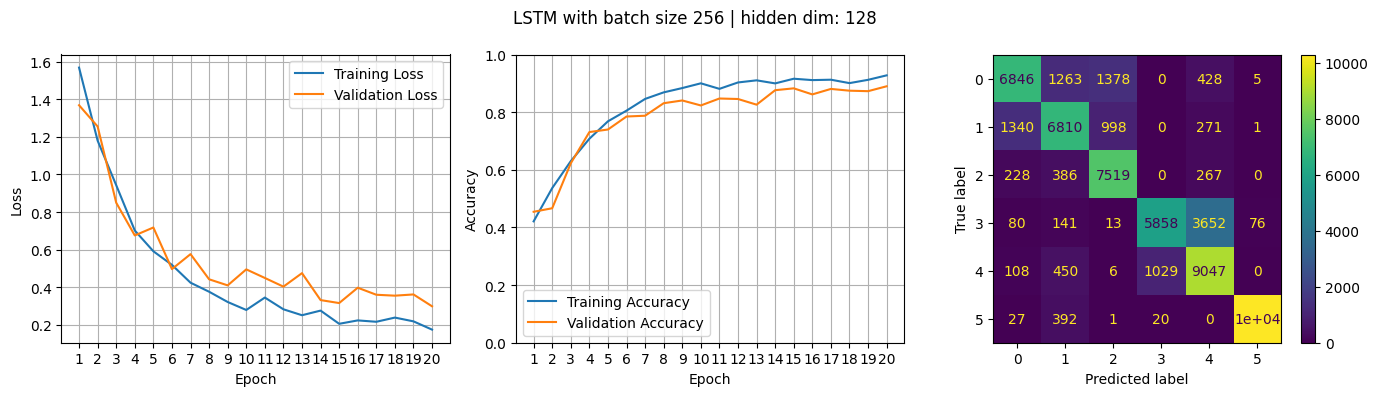

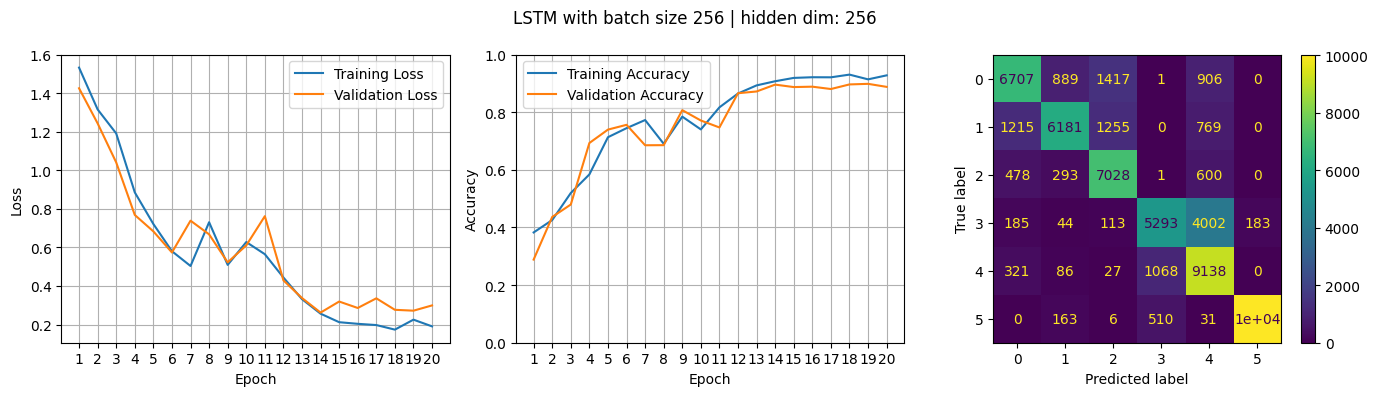

In [19]:
simple_lstm_results = {k: v for k, v in results.items() if k.startswith('LSTM with batch size')}

for key, values in simple_lstm_results.items():
    plot_loss_curve(n_epochs, values[0], values[1], values[2], values[3], values[4], values[5], key)

#### Findings

...

### Stacked LSTMs

In [20]:
### START YOUR CODE
n_epochs = 20
batch_sizes = [64, 128, 256]
input_dim = X_train.shape[2]
hidden_dims = [64, 128, 256]
output_dim = len(np.unique(Y_train))

for batch_size in batch_sizes:
    train_loader = DataLoader(train_data, batch_size, shuffle=False)
    val_loader = DataLoader(test_data, batch_size, shuffle=False)

    for hidden_dim in hidden_dims:
        model = LSTM(input_dim, hidden_dim, output_dim, n_layers=2).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters())

        train_losses, test_losses, train_accs, test_accs, y_preds, y_trues = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)
        results[f'Stacked LSTM with batch size {batch_size} | hidden dim: {hidden_dim}'] = train_losses, test_losses, train_accs, test_accs, y_preds, y_trues

Training Progress: 100%|██████████| 580/580 [02:02<00:00,  4.75it/s, Epoch=20/20, Train Loss=0.1649, Val Loss=0.2925, Train Acc=0.9368, Val Acc=0.8924]


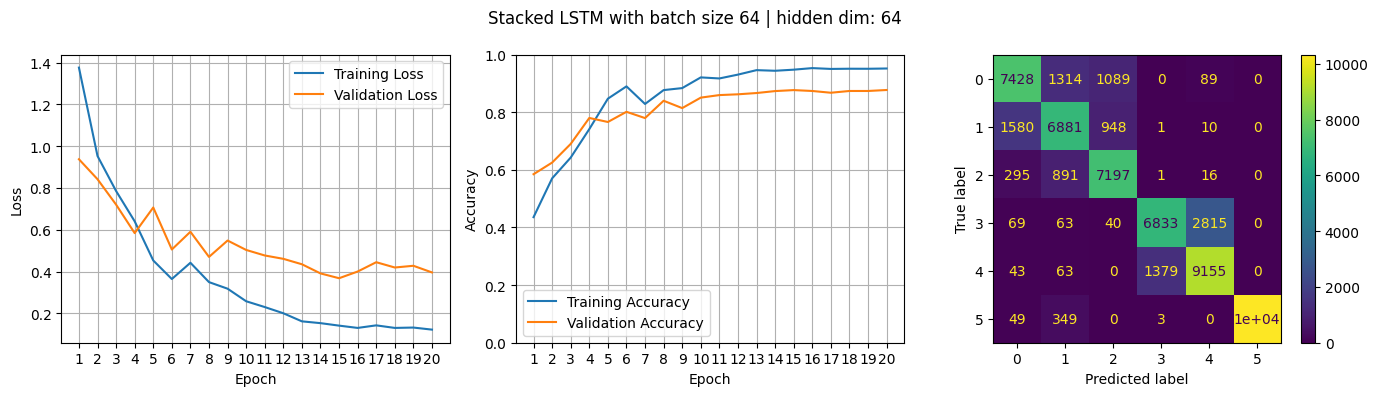

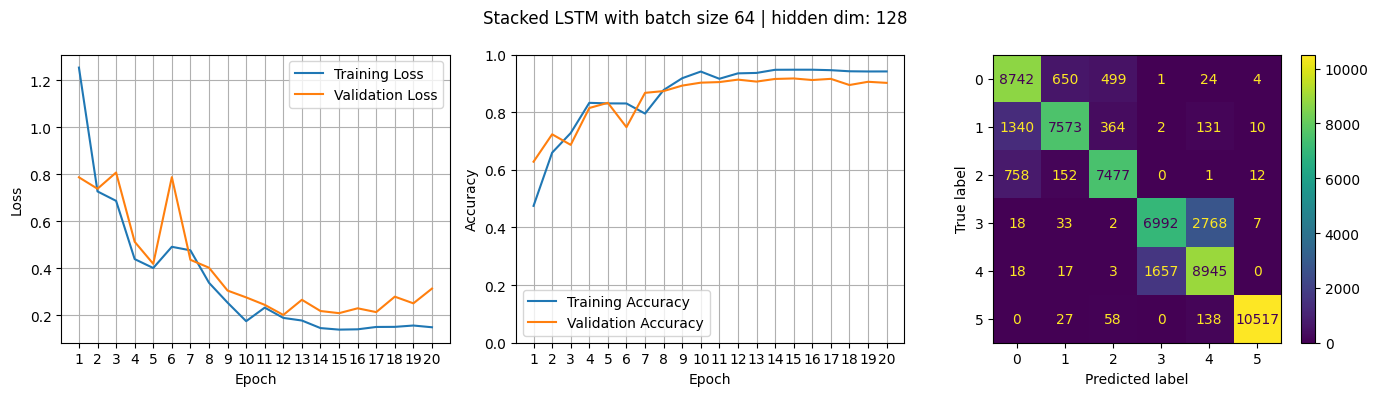

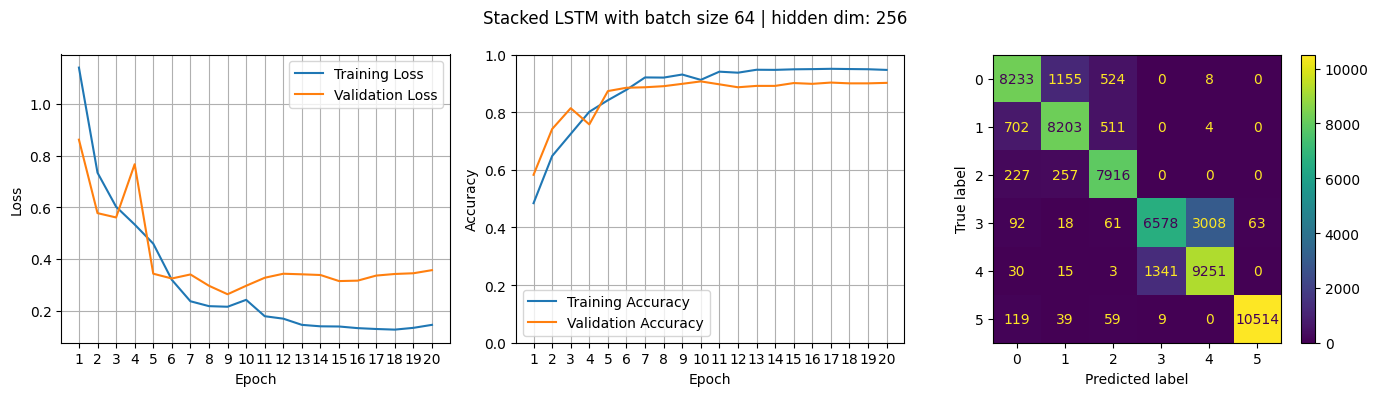

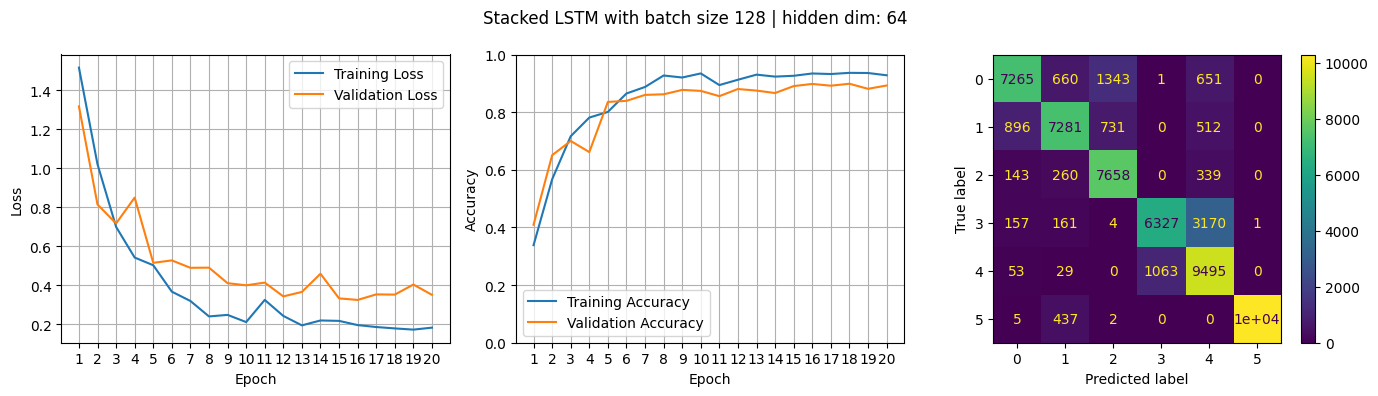

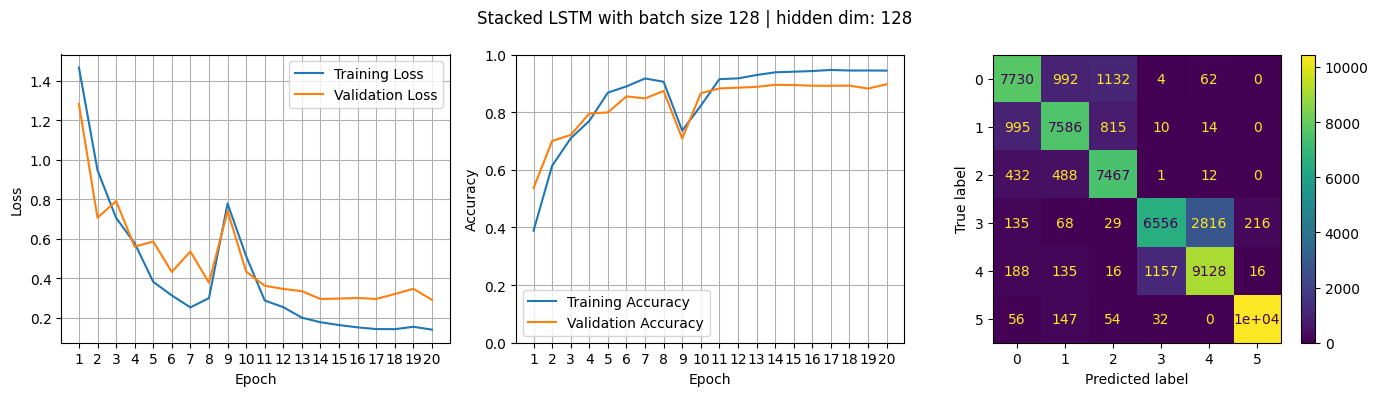

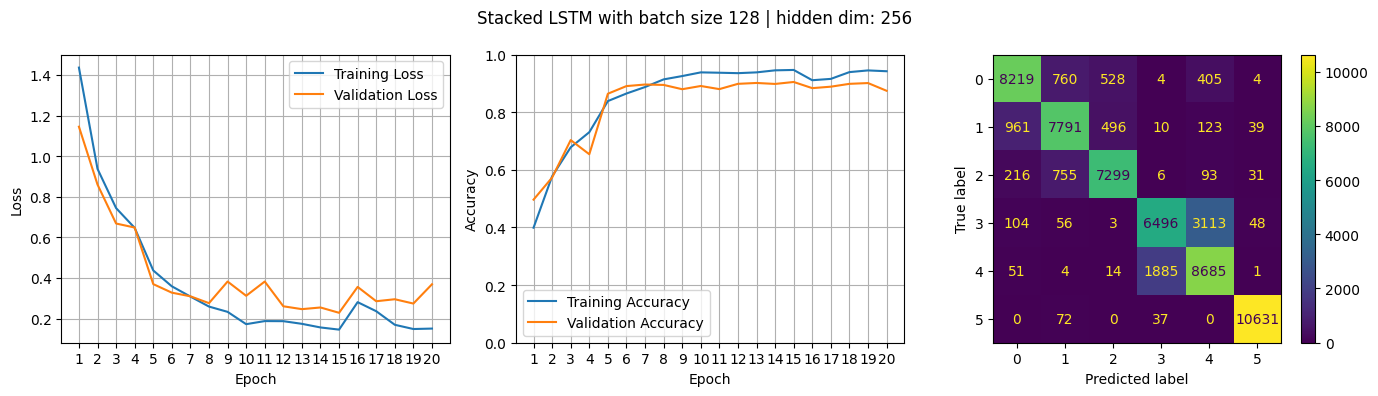

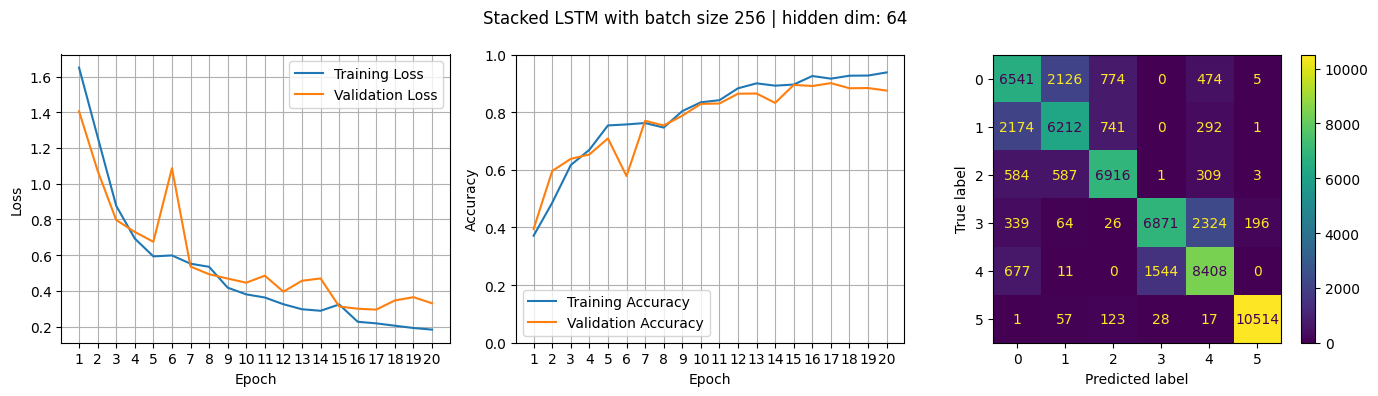

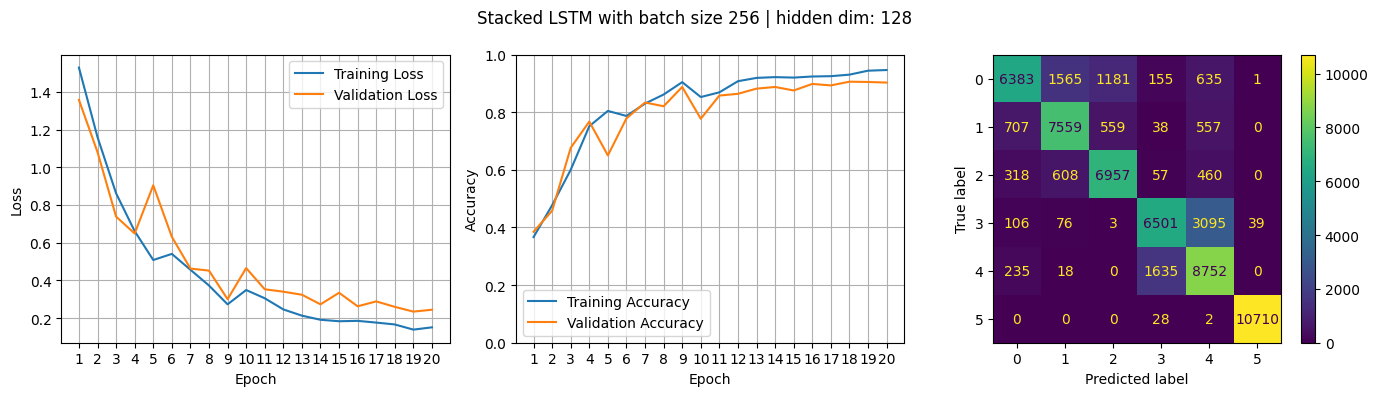

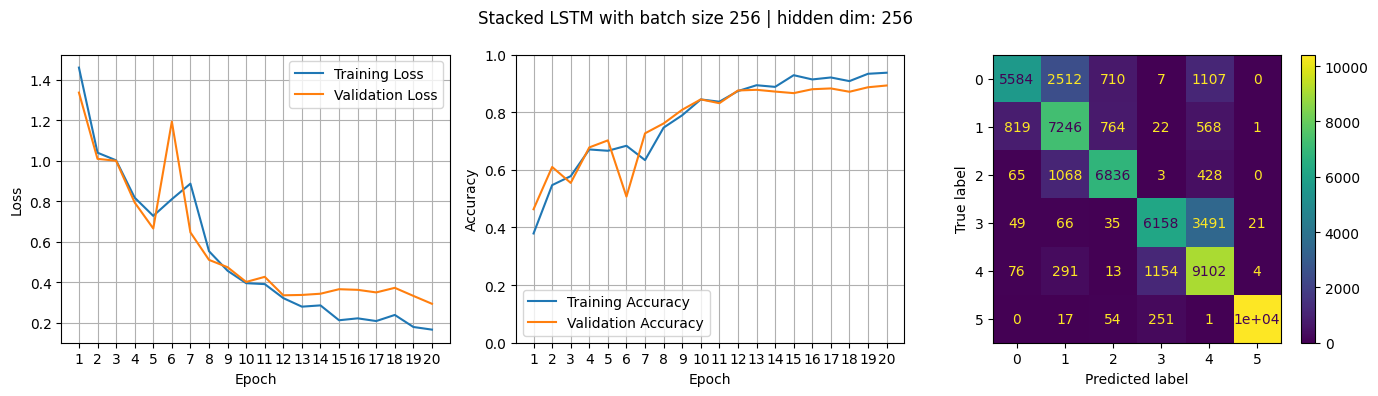

In [21]:
stacked_lstm_results = {k: v for k, v in results.items() if k.startswith('Stacked LSTM with batch size')}

for key, values in stacked_lstm_results.items():
    plot_loss_curve(n_epochs, values[0], values[1], values[2], values[3], values[4], values[5], key)

#### Findings

...

### CNN (Conv1d)

In [22]:
### START YOUR CODE

class CNN(nn.Module):
    def __init__(self, out_channels, num_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=9, out_channels=out_channels, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.fc = nn.Linear(64*out_channels, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.pool(F.relu(self.conv1(x)))
        return self.fc(torch.flatten(x, 1))

### END YOUR CODE

In [23]:
### START YOUR CODE
n_epochs = 10
batch_sizes = [64, 128, 256]
out_channels = [32, 64, 128]
num_classes = len(np.unique(Y_train))

for batch_size in batch_sizes:
    train_loader = DataLoader(train_data, batch_size, shuffle=False)
    val_loader = DataLoader(test_data, batch_size, shuffle=False)

    for out_channel in out_channels:
        model = CNN(out_channel, num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters())

        train_losses, test_losses, train_accs, test_accs, y_preds, y_trues = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)
        results[f'CNN with batch size {batch_size} | out_channel: {out_channel}'] = train_losses, test_losses, train_accs, test_accs, y_preds, y_trues

Training Progress: 100%|██████████| 290/290 [00:03<00:00, 77.63it/s, Epoch=10/10, Train Loss=0.1476, Val Loss=0.4101, Train Acc=0.9411, Val Acc=0.8707]


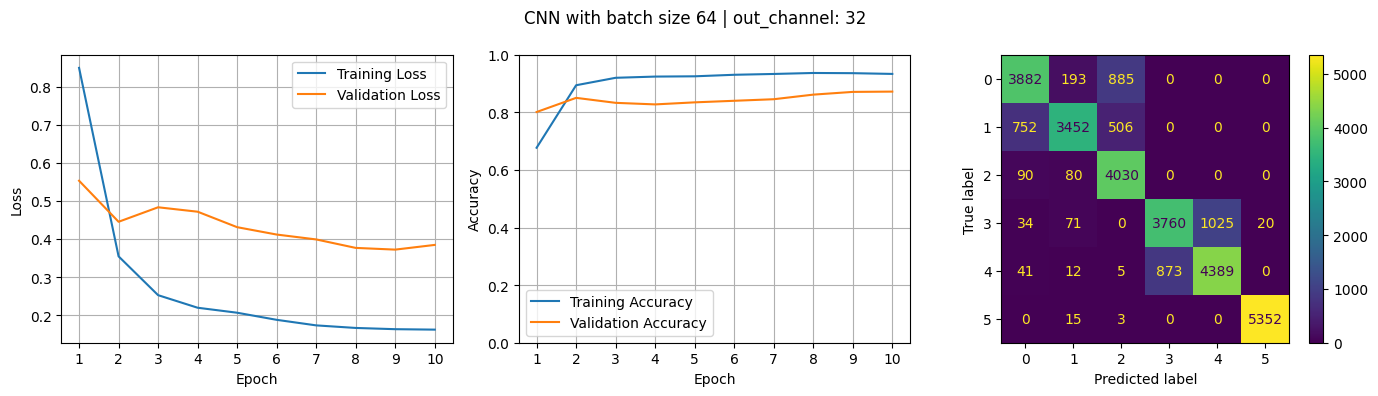

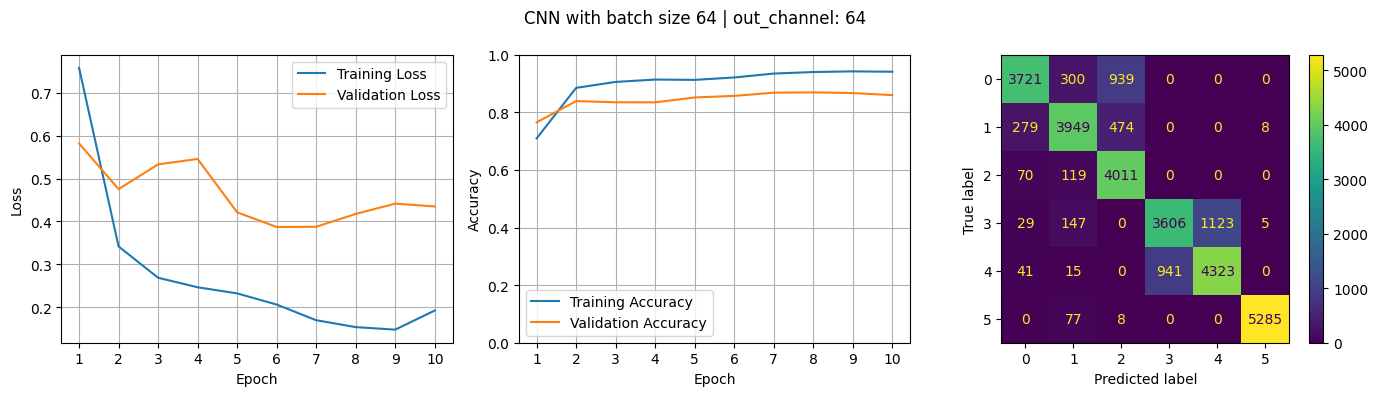

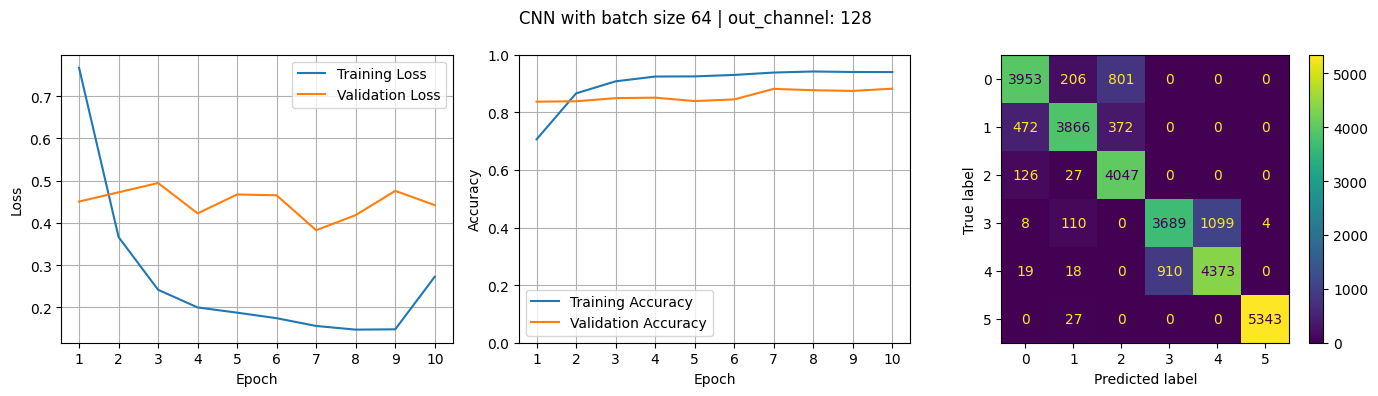

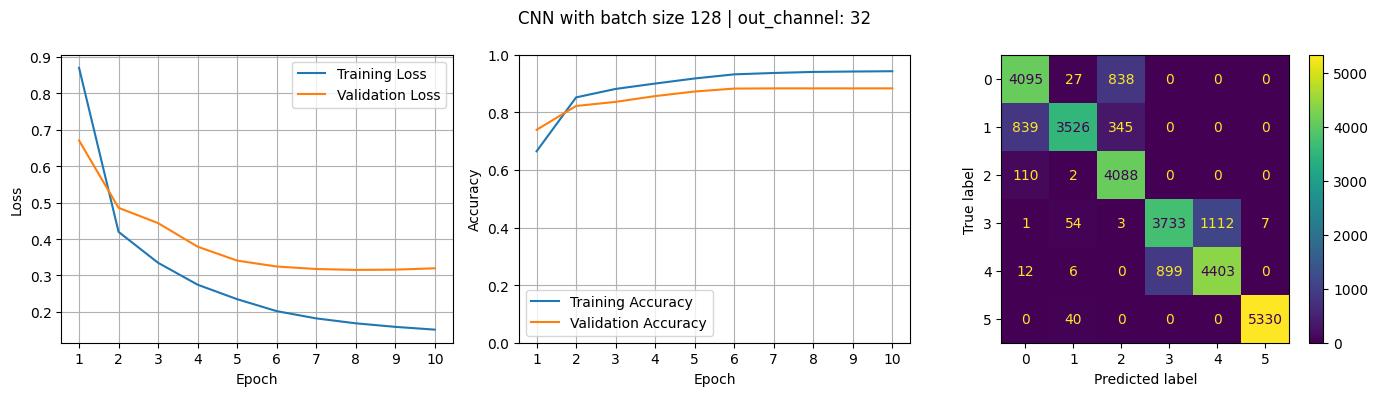

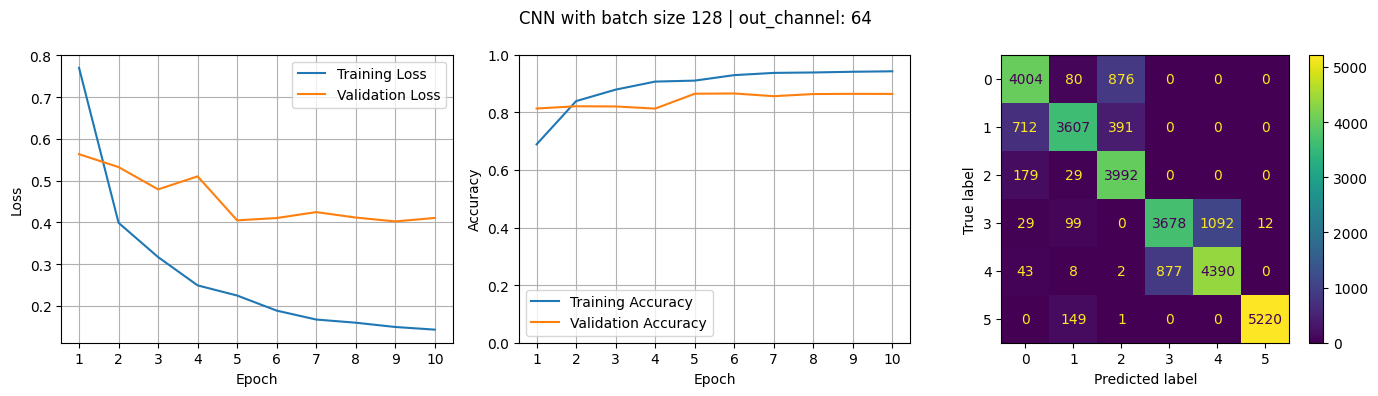

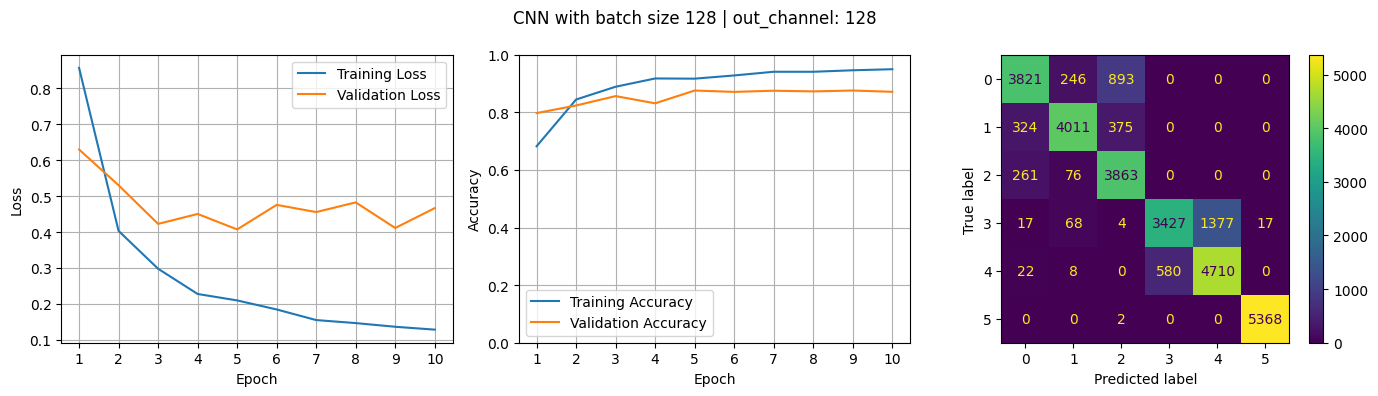

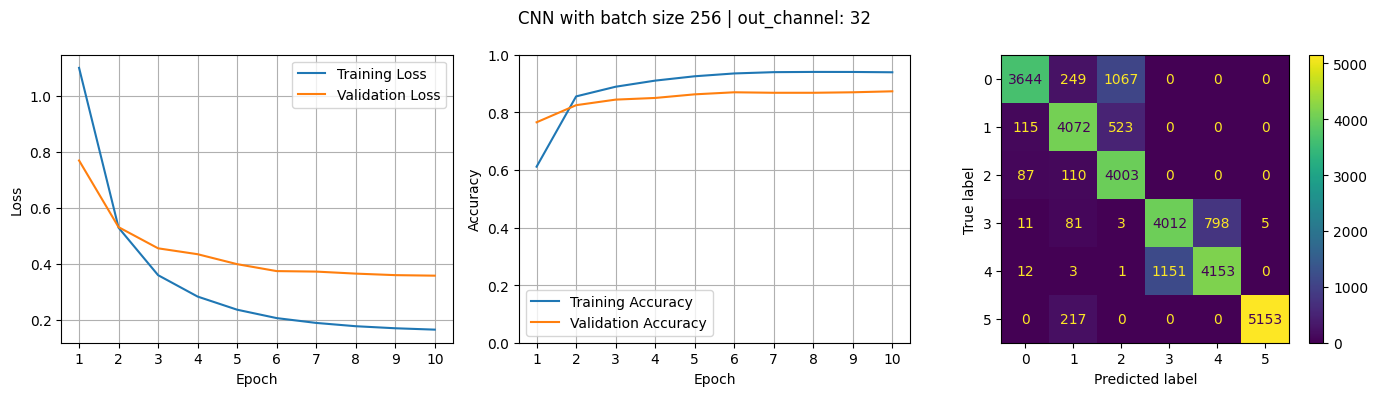

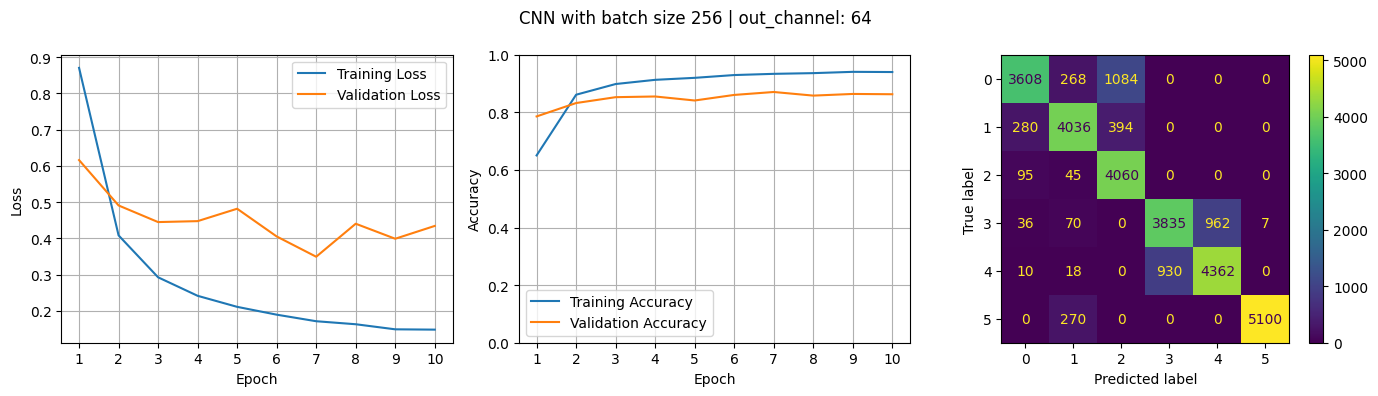

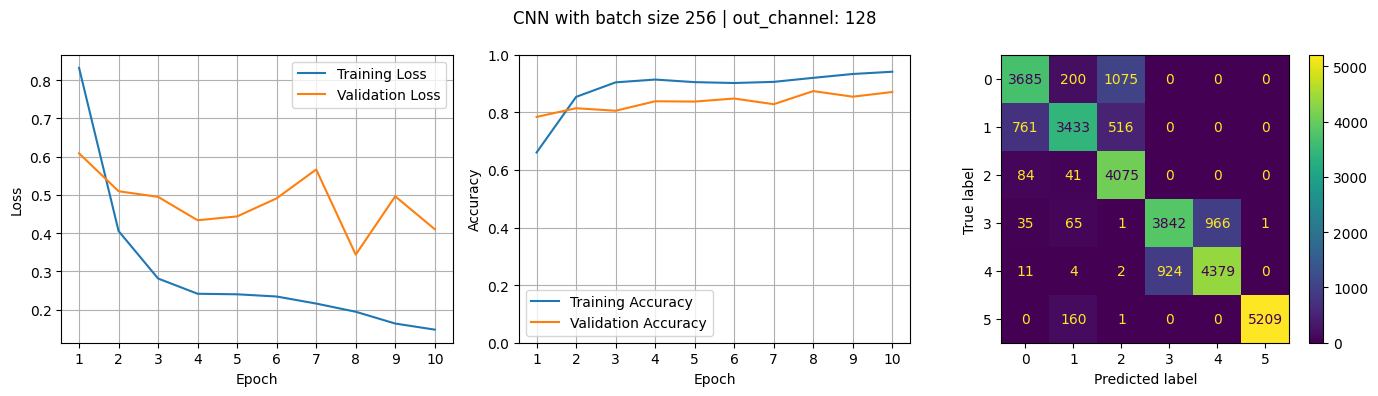

In [24]:
simple_cnn_results = {k: v for k, v in results.items() if k.startswith('CNN with batch size')}

for key, values in simple_cnn_results.items():
    plot_loss_curve(n_epochs, values[0], values[1], values[2], values[3], values[4], values[5], key)

#### Findings

...

### MLP

In [25]:
### START YOUR CODE

class MLP(nn.Module):
    def __init__(self, seq_len, num_features, hidden_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(seq_len*num_features, hidden_dim, bias=True)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


### END YOUR CODE

In [26]:
### START YOUR CODE
n_epochs = 10
batch_sizes = [64, 128, 256]

seq_len = X_train.shape[1]
num_features = X_train.shape[2]
hidden_dims = [64, 128, 256]
num_classes = len(np.unique(Y_train))

for batch_size in batch_sizes:
    train_loader = DataLoader(train_data, batch_size, shuffle=False)
    val_loader = DataLoader(test_data, batch_size, shuffle=False)

    for hidden_dim in hidden_dims:
        model = MLP(seq_len, num_features, hidden_dim, num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters())

        train_losses, test_losses, train_accs, test_accs, y_preds, y_trues = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)
        results[f'MLP with batch size {batch_size} | hidden_dim: {hidden_dim}'] = train_losses, test_losses, train_accs, test_accs, y_preds, y_trues

Training Progress: 100%|██████████| 290/290 [00:01<00:00, 191.97it/s, Epoch=10/10, Train Loss=0.1098, Val Loss=0.2548, Train Acc=0.9484, Val Acc=0.9121]


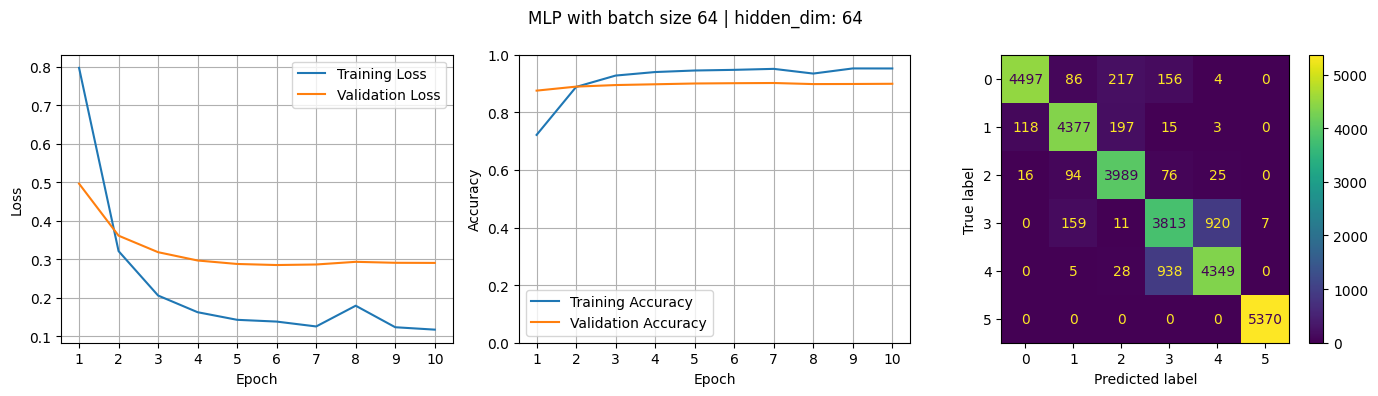

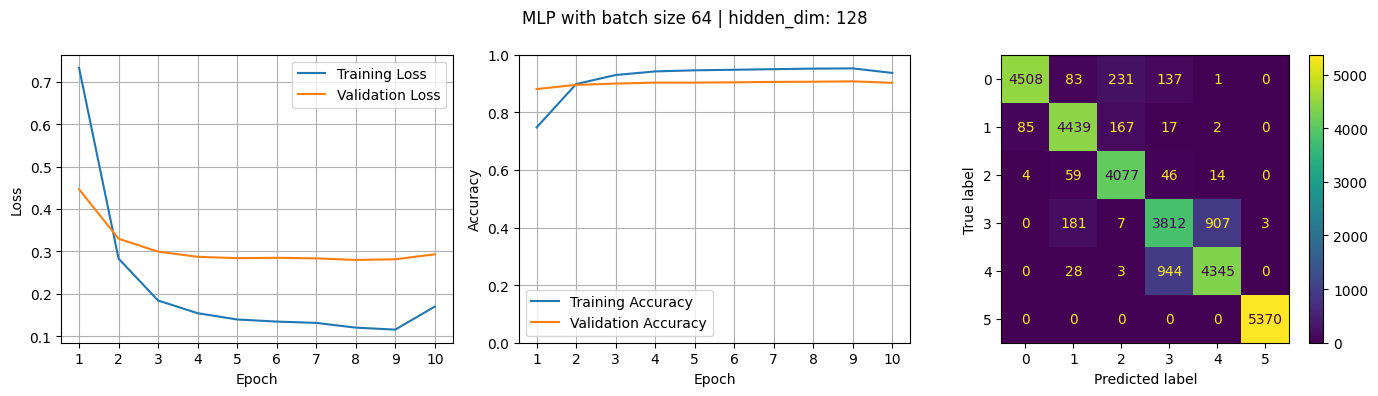

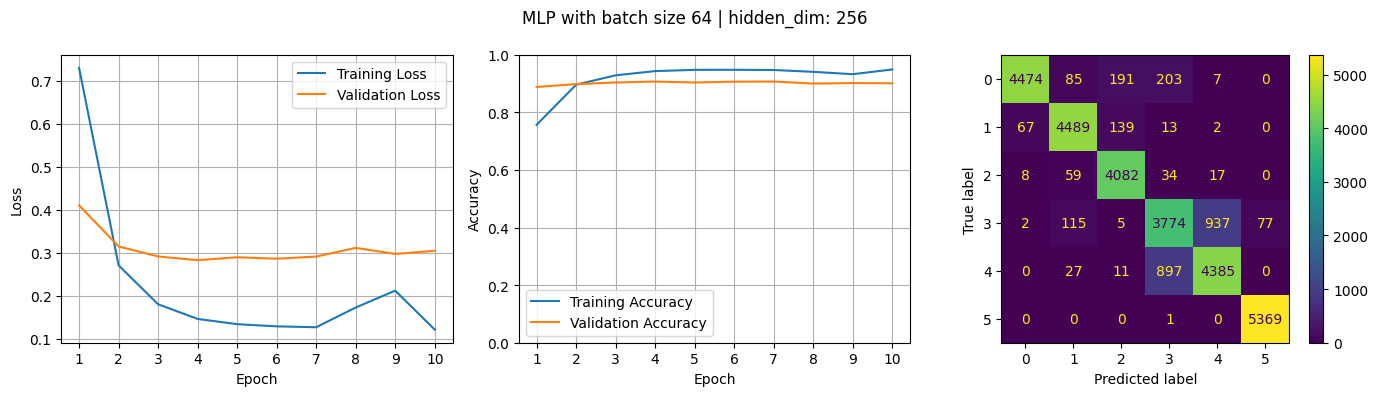

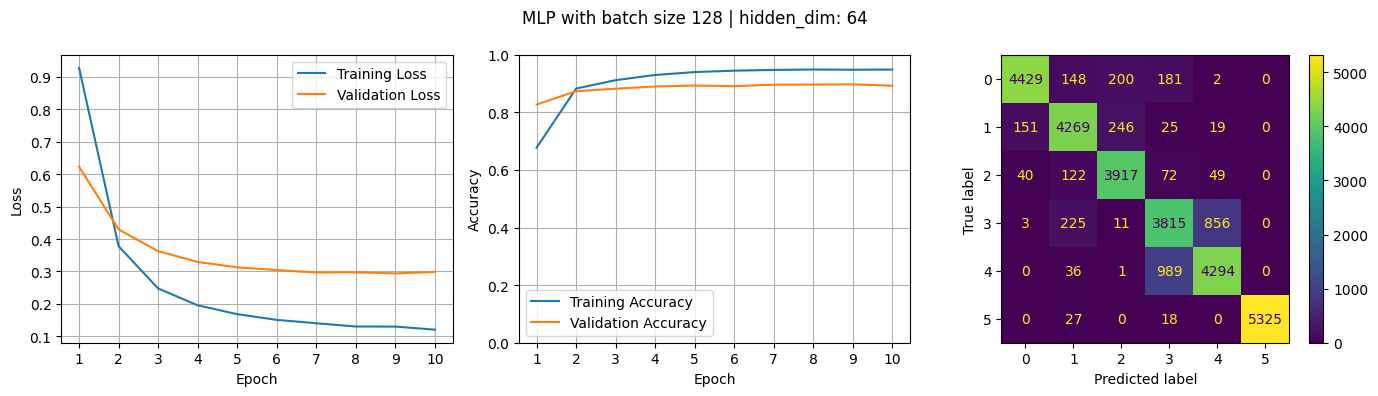

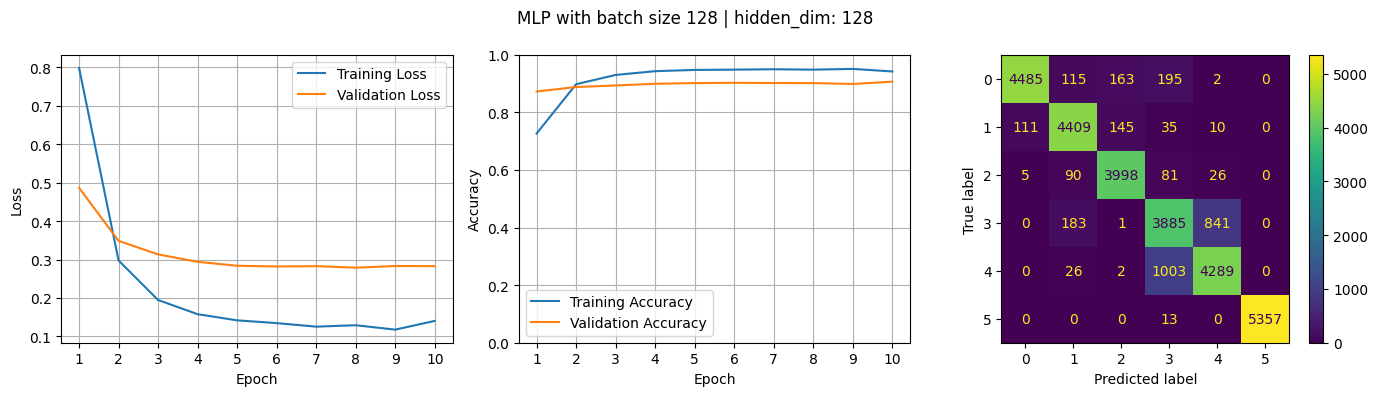

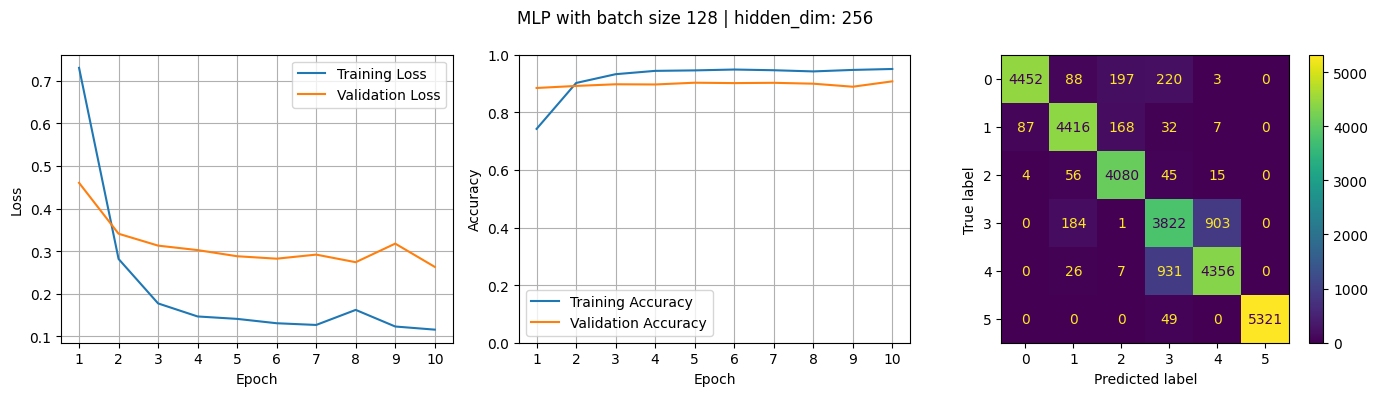

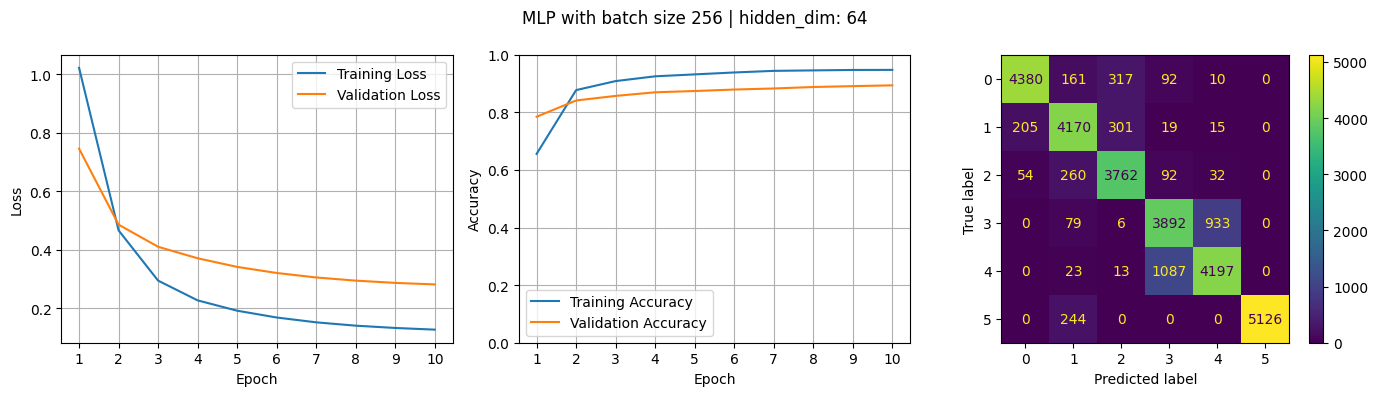

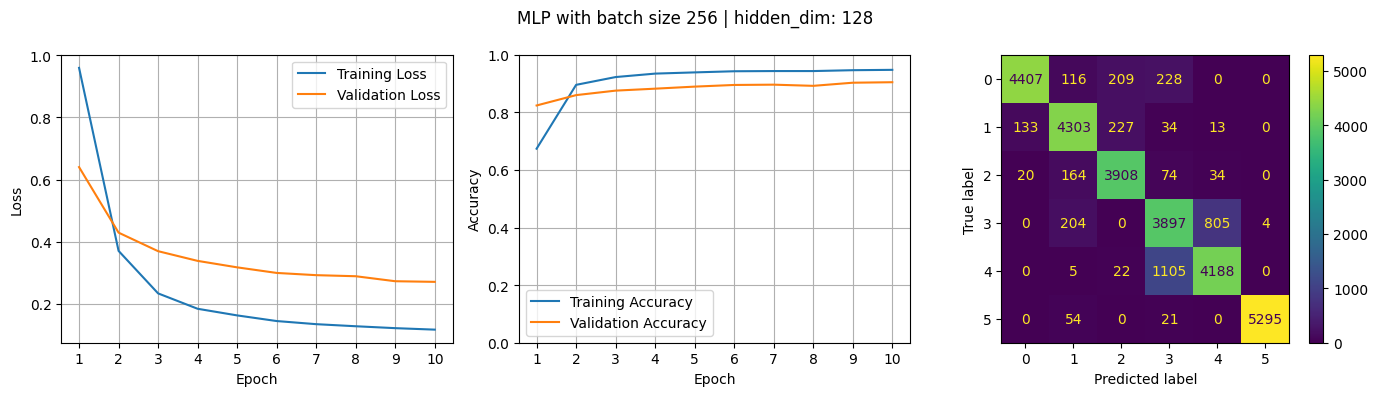

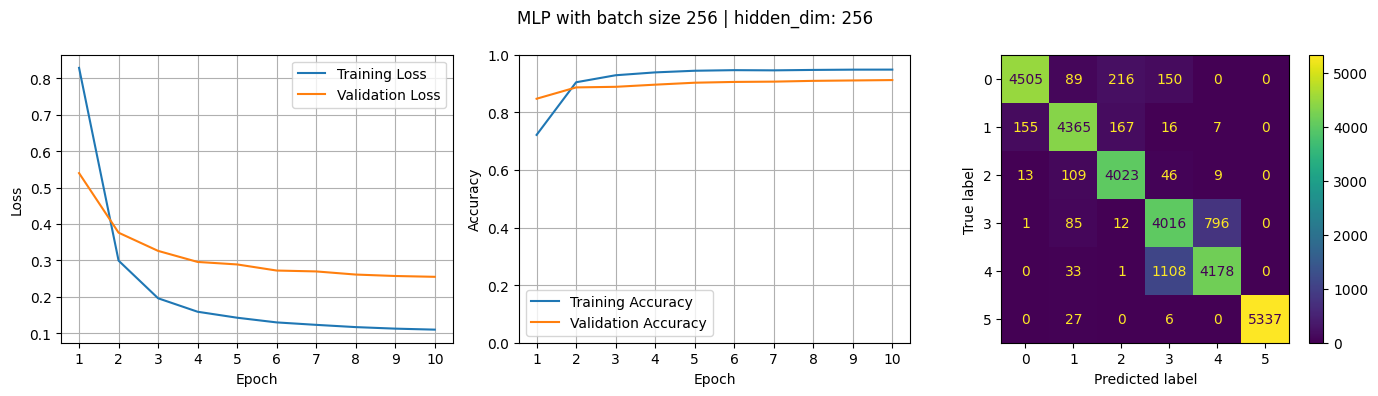

In [27]:
simple_mlp_results = {k: v for k, v in results.items() if k.startswith('MLP with batch size')}

for key, values in simple_mlp_results.items():
    plot_loss_curve(n_epochs, values[0], values[1], values[2], values[3], values[4], values[5], key)

#### Findings

...

In [ ]:
with open("results.pkl", "wb") as f:
    pickle.dump(results, f)